In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mc
import copy

action2vect = {0: np.array([0, -1]),
               1: np.array([0, +1]),
               2: np.array([-1, 0]),
               3: np.array([+1, 0])
               }

a2m = {0:'up', 1:'down', 2:'left', 3:'right'}

def random_initialize(Maze, threshold):
    x = np.random.randn(Maze.lx*Maze.ly).reshape(Maze.lx, Maze.ly)
    y = (x < threshold)*(x > -threshold)
    Maze.tile = y
    Maze.load_tile()
    
    floor_labels = np.arange(len(Maze.floors))
    start_floor_label = np.random.choice(floor_labels)
    goal_floor_label = np.random.choice(floor_labels)
    Maze.goal = Maze.floors[goal_floor_label].tolist()
    return Maze
        
class MazeEnv():
    def __init__(self, lx, ly, threshold=0.9, figsize=5, const=0):
        self.lx, self.ly = lx, ly
        
        self = random_initialize(self, threshold)
        self.reset()
        
        self.action_space = [0,1,2,3]
        self.status = 'Initialized'
        self.figsize = figsize

        self.reward_const = const
        self.reward_goal = 1
        self.reward_usual = 0
    def reset(self, coordinate=[None, None]):
        """
        put the agent at certain coordinate randomly.
        """
        floor_labels = np.arange(len(self.floors))
        start_floor_label = np.random.choice(floor_labels)
        self.state = self.floors[start_floor_label]
        self.status = 'Reset'
        self.t = 0
        return self.get_state()
        
    def is_solved(self):
        return self.goal==self.state.tolist()
    
    def get_state(self):
        return copy.deepcopy(self.state)#
            
    def get_next_state(self, state, action):
        add_vector_np = action2vect[action]
        if (state+add_vector_np).tolist() in self.floors.tolist():
            next_state = state+add_vector_np
            self.status = 'Moved'
        else:
            next_state = state
            self.status = 'Move failed'
        self.t += 1
        return next_state
    
    def get_reward(self, state, action, state_p):
        if state_p.tolist()==self.goal:
            reward = self.reward_goal
        elif False:
            reward = 0.1
        else:
            reward = self.reward_usual
        return reward + self.reward_const
    
    def step(self, action):
        state = self.get_state()
        next_state = self.get_next_state(state, action)
        reward = self.get_reward(state, action, next_state)
        self.state = next_state
        return self.get_state(), reward, self.is_solved(), {}
        
    def load_tile(self):
        self.floors = np.array(list(np.where(self.tile==True))).T # (#white tiles, 2), 2 means (x,y) coordinate
        self.holes = np.array(list(np.where(self.tile==True))).T # (#black tiles, 2)
    
    def render_tile(self, ax, cmap='gray'):
        ax.imshow(self.tile.T, interpolation="none", cmap=cmap, vmin=0, vmax=1)
        return ax
    
    def render_arrows(self, ax, values_table):
        lx, ly, _ = values_table.shape
        vmins = np.min(values_table, axis=2).reshape(lx, ly, 1)
        offset = - vmins
        vnoed = values_table*self.tile.reshape(lx, ly, 1) + offset 
        vnoed_maxs = np.max(vnoed, axis=2).reshape(lx, ly, 1)
        vt = np.transpose(vnoed/(vnoed_maxs), (1,0,2))
        width = 0.5
        X, Y= np.meshgrid(np.arange(0, lx, 1), np.arange(0, ly, 1))
        ones = .5*np.ones(lx*ly).reshape(lx, ly)
        zeros= np.zeros(lx*ly).reshape(lx, ly)
        ax.quiver(X, Y, zeros, ones, vt[:,:,0], alpha=0.8, cmap='Reds', scale_units='xy', scale=1) # up
        ax.quiver(X, Y, zeros, -ones, vt[:,:,1], alpha=0.8, cmap='Reds', scale_units='xy', scale=1)# down
        ax.quiver(X, Y, -ones, zeros, vt[:,:,2], alpha=0.8, cmap='Reds', scale_units='xy', scale=1)# left
        ax.quiver(X, Y, ones, zeros, vt[:,:,3], alpha=0.8, cmap='Reds', scale_units='xy', scale=1) # right
        return ax
        
    def render(self, fig=None, ax=None, lines=None, values_table=None, canvas=False):
        if ax is None:
            fig = plt.figure(figsize=(self.figsize, self.figsize))
            ax = fig.add_subplot(111)
            ax.set_xlabel('x'); ax.set_ylabel('y')
        ax = self.render_tile(ax)
        if values_table is not None:
            ax = self.render_arrows(ax, values_table)
        if self.goal is not None:
            ax.scatter(self.goal[0], self.goal[1], marker='d', s=100, color='red', alpha=0.8, label='goal')
        if self.state is not None:
            ax.scatter(self.state[0], self.state[1], marker='o', s=100, color='black', alpha=0.8, label='agent')
        if lines is not None:
            lc = mc.LineCollection(lines, linewidths=2, color='black', alpha=0.5)
            ax.add_collection(lc)   
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', scatterpoints=1)
        if canvas:
            return ax
        else:
            plt.show()
                      
    def play(self, Agent, show=True, fig=None, ax=None, canvas=False):
        lines = []
        while not self.is_solved():
            state0 = self.get_state()
            action = Agent.play()
            self.step(action)
            state1 = self.get_state()
            lines.append([state0, state1])
        if show:
            return self.render(fig=fig, ax=ax, lines=lines, canvas=canvas)

class Agent():
    def __init__(self, policy):
        self.policy = policy
        
    def play(self):
        """
        return a number in [0,1,2,3] corresponding to [up, down, left, right]
        """
        return self.policy.sample()        

class Policy():
    def __init__(self):
        pass
        
class Optimizer():
    def __init__(self):
        pass

## 9-3. 行動価値推定に基づくRL
バンディット問題において、推定した価値関数に基づいたε-greedy方策が上手く行っていました。ここではそれの強化学習版を説明します。

### 方策改善定理
まず、理論パートとして、ε-greedy方策が パフォーマンス $J(\pi)$ を改善することを数学的に証明します。

つまり任意の古い方策 $\pi_{old}$ として、この方策に基づいた行動価値 $q_{\pi_{old}}(s, a)$ が得られているとし、新しい方策としてε-greedy方策

$$
\pi_{new}(a|s) =  \left\{ \begin{array}{ll}
1_{q_{\pi_{old}}(s, a) = \max_a' q_{\pi_{old}}(s, a') } & prob = 1- \epsilon \\
\frac{1}{|A|} & prob=\epsilon \\
\end{array} \right.
$$

を取ったとき、

$$
J(\pi_{old}) \leq J(\pi_{new})
$$

であることを示します。

#### 鍵となる不等式
まずは以下の不等式を示します：

|$\qquad \qquad$ 鍵となる不等式 $\qquad \qquad$|
|:---:|
|$v_{\pi_{old}}(s) \leq \langle q_{\pi_{old}}(s, a) \rangle_{a \sim \pi_{new}(\cdot | s)}$|


右辺から始めます：

$$
\left. \begin{array}{ll}
\langle q_{\pi_{old}(s, a)} \rangle_{a \sim \pi_{new}(\cdot | s)} & = \sum_{a} \pi_{new}(a | s) q_{\pi_{old}}(s, a) \\
&= \frac{\epsilon}{|A|} \sum_a q_{\pi_{old}}(s, a) + (1-\epsilon) {\color{red}{\max_{a'} q_{\pi_{old}}(s, a')}} \tag{1}
\end{array} \right.
$$

2行目で ε-greedy方策の定義を使いました。2項目について、どんな重み $\alpha_a$ を持ってきても ${\color{red}{\max_{a'} q_{\pi_{old}}(s, a')}} \geq \sum_{a} \alpha_{a} q_{\pi_{old}}(s, a)$ が成り立つので、

$$
\alpha_a = \frac{\pi_{old}(a|s) - \frac{\epsilon}{|A|}}{1-\epsilon}
$$

を使うと

$$
\left. \begin{array}{ll}
(1) &\geq \frac{\epsilon}{|A|} \sum_a q_{\pi_{old}}(s, a) + (1-\epsilon) \sum_{a} \frac{\pi_{old}(a|s) - \frac{\epsilon}{|A|}}{1-\epsilon} q_{\pi_{old}}(s, a)\\
&= \sum_a \pi_{old}(a|s) q_{\pi_{old}}(s, a) = v_{\pi_{old}}(s)
\end{array} \right.
$$

で示せました。

#### 方策改善
実は

1. 鍵となる不等式: $v_{\pi_{old}}(s) \leq \langle q_{\pi_{old}}(s, a) \rangle_{a \sim \pi_{new}(\cdot | s)}$ 
2. ベルマン方程式: $q_\pi(s, a) = \langle r_{t+1} \rangle_{s_{t+1} \sim P_s(\cdot|s, a),\ r_{t+1} \sim P_r(\cdot|s, a, s_{t+1})}
+ \gamma \underbrace{\langle
q_\pi(s_{t+1}, a_{t+1})
\rangle_{s_{t+1} \sim P_s(\cdot|s, a),\ a_{t+1} \sim \pi(\cdot | s_{t+1})}}_{\langle v_\pi(s_{t+1})\rangle_{s_{t+1} \sim P_s(\cdot|s, a)}}$

を再帰的に使うと $v_{\pi_{old}}(s) \leq v_{\pi_{new}}(s)$ であることが以下のように示せます：

$$
\left. \begin{array}{ll}
v_{\pi_{old}}(s) & \overbrace{\leq}^{1} \langle q_{\pi_{old}}(s, a) \rangle_{a \sim \pi_{new}(\cdot | s)} \\
&\overbrace{=}^2 \big\langle 
\langle r_{t+1} \rangle_{s_{t+1} \sim P_s(\cdot|s, a),\ r_{t+1} \sim P_r(\cdot|s, a, s_{t+1})}
+ \gamma \langle
\underbrace{v_{\pi_{old}}(s_{t+1})}_{もう一度 1 を使う}
\rangle_{s_{t+1} \sim P_s(\cdot|s, a)}
\big\rangle_{a \sim \pi_{new}(\cdot | s)} \\
&\leq ... \\
& \leq \Big\langle r_{t+1} + \gamma r_{t+2} + \dots \Big\rangle_{a \sim \pi_{new}} = v_{\pi_{new}}(s)
\end{array} \right.
$$

したがって、初期状態でこれの期待値をとっても、不等式が成り立ち、

$$
J(\pi_{old}) \leq J(\pi_{new})
$$

であることがわかります。したがって

1. 適当な $\pi_0$ からスタート
2. $q_{\pi_0}(s, a)$ を計算し、この値に基づきε-greedy方策 $\pi_1$ を設定
3. $q_{\pi_1}(s, a)$ を計算し、この値に基づきε-greedy方策 $\pi_2$ を設定
4. ...

とすれば、

$$
J(\pi_0) \leq J(\pi_1) \leq J(\pi_2) \leq ...
$$

と、期待報酬が単調増加してゆくことが保証されます。そこで以下では、行動価値 $q_\pi(s, a)$ を推定した値 $Q(s,a)$ を用いたε-greedy方策を用います。実装は以下です：


In [2]:
class EpsilonGreedy(Policy):
    def __init__(self, env, epsilon=0.1, init=0.):
        self.Q = init*np.random.rand(env.lx*env.ly*4).reshape(env.lx, env.ly, 4)
        self.env = env
        self.epsilon = epsilon
    
    def sample(self):
        x, y = self.env.state
        Qs = self.Q[x, y, :] # = [Q(s, 0), Q(s, 1), Q(s, 2), Q(s, 3)]
        if np.random.rand()<1-self.epsilon:
            a = np.random.choice(np.arange(len(Qs))[(Qs == np.max(Qs))]) #np.argmax(Qs)
        else:
            a = np.random.choice(np.arange(len(Qs)))
        return a

以下の実験で共通して使う迷路を作っておきます。白い部分が連結している迷路のほうが警告などが出にくくて良いですが、閉じた部屋があっても実験可能です。

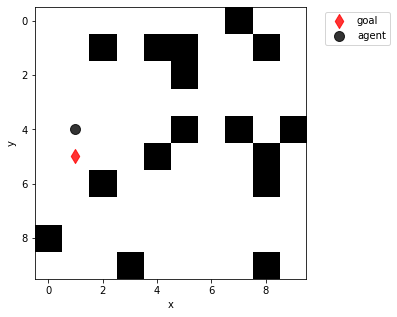

In [3]:
env = MazeEnv(10,10, threshold=1.3, figsize=5)
env.render()

### モデルフリー手法
モデルとはなにか、説明は後にします。いまは気にしないで下さい。

####  モンテカルロ法
ε-greedyを用いた方策改善の問題は、$\pi$ が与えられた時に $q_\pi(s,a)$ をどのようにして求めるか？ということです。$q$はMDPの期待値で定義されているのですが、環境や方策が複雑な場合期待値を手で計算できるとは限りません。そこで期待値を、実際に現れたサンプル平均で置き換える操作をしましょう。つまり方策改善の図式は以下のようになります：

1. 適当な $\pi_0$ からスタート
2. 
  - 実際に $\pi_0$ を使ってゲームをプレイし、 \{($s_t, r_t, a_t$) \} の系列を得る
  - $q_{\pi_0}(s, a) \approx Q(s,a) = \sum_{k} \gamma^k r_{t+1+k}$ を計算し$^※$、この値に基づきε-greedy方策 $\pi_1$ を設定
3. 
  - 実際に $\pi_1$ を使ってゲームをプレイし、 \{($s_t, r_t, a_t$) \} の系列を得る
  - $q_{\pi_1}(s, a) \approx Q(s,a) =  \sum_{k} \gamma^k r_{t+1+k}$ を計算し$^※$、この値に基づきε-greedy方策 $\pi_2$ を設定
4. ...

> $^※$ ここでは $s, a$ として初めて訪れた場合のみ勘定に入れる方法を取ることにします。また、実装の簡単さから平均を計算するのに1サンプルのみしか使いません。平均値計算に1サンプルだけしか使わないのは結構な罪のように思われますが、このノートでは終始この計算戦略を取ります。もちろんサンプル数を増やしたほうが性能は良くなりますので、気になる方は改造して実験してみて下さい。

これを制御するクラスを作っておきます。使い方は

- `__init__(agent, gamma)`: オブジェクト作成時にエージェントと$\gamma$の値を指定
- `reset()`: 履歴を削除
- `record_hist(s, a, r_next)`: 履歴を保存
- `update`: 溜まった履歴で $q$ を近似計算し、エージェントの$q$=`Q`を更新する

です。

In [4]:
class MC_optimizer(Optimizer):
    def __init__(self, agent, gamma):
        self.agent = agent
        self.Q = agent.policy.Q
        self.gamma = gamma
        self.Nupdate = 0
        
        self.Gs = np.zeros((agent.policy.env.lx, agent.policy.env.ly, 4)) # 毎回のエピソード報酬和の記録
        self.visit = np.zeros((agent.policy.env.lx, agent.policy.env.ly, 4)) # 何回そこを訪れたか数える
        
    def reset(self):
        self.SAhist = []
        self.Rhist = [0]
        # tipsですが、以下の２つをコメントアウトすると性能が飛躍的に向上します。なぜでしょう？
        self.Gs = np.zeros((agent.policy.env.lx, agent.policy.env.ly, 4)) # 毎回のエピソード報酬和の記録
        self.visit = np.zeros((agent.policy.env.lx, agent.policy.env.ly, 4)) # 何回そこを訪れたか数える
        
    def record_hist(self, s, a, r_next):
        x, y = s
        self.SAhist.append((x, y, a))
        self.Rhist.append(r_next)
        
    def update(self):
        self.Nupdate+=1
        G = 0
        for t in np.arange(len(self.Rhist)-1)[::-1]:
            G = self.gamma*G + self.Rhist[t+1]
            if not self.SAhist[t] in self.SAhist[:t]: # 最初に訪問したところだけ勘定
                x, y, a = self.SAhist[t]
                self.Gs[x, y, a] += G
                self.visit[x, y, a] += 1
                self.Q[x, y, a] = self.Gs[x, y, a]/self.visit[x, y, a]

早速実験です。パラメータは適当です。色々いじって遊んでみて下さい。

In [5]:
%%time
agent = Agent(policy=EpsilonGreedy(env=env, init=0.01))
Opt = MC_optimizer(agent, gamma=0.2)
N_episode = 500

for episode in range(N_episode):
    env.reset()
    Opt.reset()
    while not env.is_solved():
        s = env.get_state()
        a = agent.play()
        s_next, r_next, _, _ = env.step(a)
        Opt.record_hist(s, a, r_next) # この時刻での s, a, r_next を記録
        if env.t > 100: # たまにゴールできない位置に置かれてしまうので
            break
    Opt.update() # 記録から現在の方策での Q の値を計算し、ε-greedy を更新する（ここで方策改善）

CPU times: user 1.73 s, sys: 15.7 ms, total: 1.74 s
Wall time: 1.76 s


最終的に得られた方策を用いた迷路ゲームプレイと、その方策を表示します：

/Users/akinoritanaka/.pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/ipykernel/__main__.py:98: RuntimeWarning: invalid value encountered in true_divide


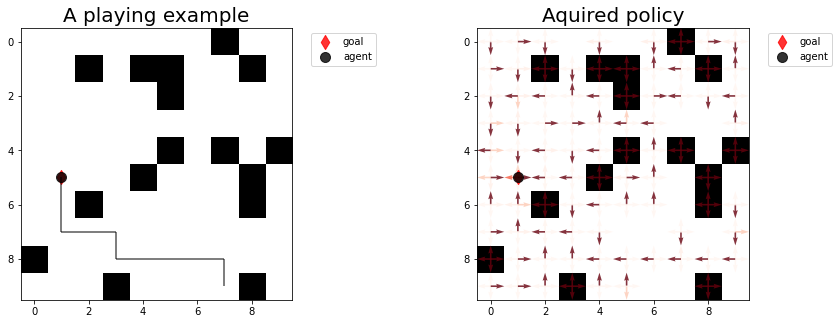

In [6]:
env.reset()

fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(121); ax1.set_title("A playing example", fontsize=20) 
ax2 = fig.add_subplot(122); ax2.set_title("Aquired policy", fontsize=20) 

env.play(agent, fig=fig, ax=ax1, canvas=True)
env.render(fig=fig, ax=ax2, values_table=agent.policy.Q)

このように、ある程度、迷路を解く＝方策改善していることがわかります。しかし完全には解けておらず、ところどころ方策が定まっていないマスがあります。ここまではベルマン方程式を全く使っていません。ベルマン方程式はMDPのダイナミクスを上手く表現した式なので、これを使った制御をすると性能が上がると期待されます。やってみましょう。

#### SARSA
ベルマン方程式の近似として、MDPのサンプル系列

$$
\left. \begin{array}{l:ll:ll:ll}
\dots
&
s
&
{\to}
a
{\to} 
&
s_\text{next}
&
{\to}
a_\text{next}
{\to} 
&
 \cdots
\\
&&&
\downarrow
\\
&-
&&
r_\text{next}
\end{array} \right.
$$

があったとき、期待値を1サンプルで近似すると

$$
Q(s, a) = r_\text{next} + \gamma Q(s_\text{next}, a_\text{next})
$$

としても良さそうです。つまり$Q(s,a)$についての「誤差関数」

$$
l(Q) = \frac{1}{2} 
\Big(Q(s,a) - \big[ r_\text{next} + \gamma Q(s_\text{next}, a_\text{next}) \big] \Big)^2
$$

を減らせば良さそうです。ニューラルネットの学習よろしく、勾配法でアップデートすることにすれば

$$
\left. \begin{array}{ll}
Q(s,a) &\leftarrow 
Q(s,a) - \eta \nabla_{Q(s,a)} l(Q)
\\
&= 
Q(s,a) - \eta \underbrace{ \Big(Q(s,a) - \big[ r_\text{next} + \gamma Q(s_\text{next}, a_\text{next}) \big] \Big)}_\text{TD error}
\end{array} \right.
$$

を実際のMDPでのサンプル毎に更新すればよいでしょう。
更新する分の部分を**Temporal Difference error(TD error)**と言います。TD errorの部分に順に$s, a, r_\text{next}, s_\text{next}, a_\text{next}$が出てきていることから、この方法を**SARSA**といいます。

In [7]:
class SARSA_optimizer(Optimizer):
    def __init__(self, agent, eta, gamma):
        self.agent = agent
        self.Q = agent.policy.Q
        self.eta = eta
        self.gamma = gamma

    def update(self, s, a, r_next, s_next):
        a_next = self.agent.play() # 一回プレイさせてa_nextをサンプル(環境には作用させない実装)
        x, y = s
        x_next, y_next = s_next
        TD_error = self.Q[x, y, a] - (r_next + self.gamma*self.Q[x_next, y_next, a_next])
        self.Q[x, y, a] -= self.eta*TD_error

以下では

1. 状態$s$, 現在の推定値 $Q$ をもちいたε-greedyで一回行動$a$
2. $s, a$ と 得られた $r_\text{next}, s_\text{next}$ を用いて $Q$ を SARSA で更新
3. ゴールに辿り着いていればランダムな位置に置き直す

を繰り返して、方策の改善を図ります。ポイントですが、最早モンテカルロ法では無いので、**方策の更新は各時刻で行われます**。


In [8]:
%%time
agent = Agent(policy=EpsilonGreedy(env=env, init=0.01))
Opt = SARSA_optimizer(agent, eta=1., gamma=0.2)
N_episode = 500

for episode in range(N_episode):
    env.reset()
    while not env.is_solved():
        s = env.get_state()
        a = agent.play()
        s_next, r_next, _, _ = env.step(a)
        Opt.update(s, a, r_next, s_next)
        if env.t > 100: # たまにゴールできない位置に置かれてしまうので
            break

CPU times: user 960 ms, sys: 29.8 ms, total: 989 ms
Wall time: 974 ms


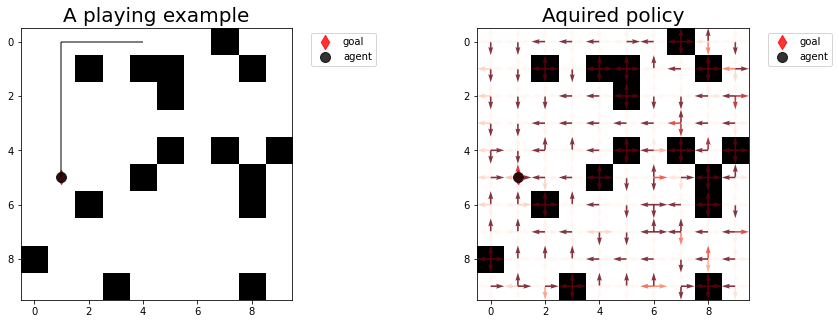

In [9]:
env.reset()

fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(121); ax1.set_title("A playing example", fontsize=20) 
ax2 = fig.add_subplot(122); ax2.set_title("Aquired policy", fontsize=20) 

env.play(agent, fig=fig, ax=ax1, canvas=True)
env.render(fig=fig, ax=ax2, values_table=agent.policy.Q)

モンテカルロ法と同じエピソード数にもかかわらず、随分よくなりました。速度も倍近く早くなっているのがわかります。モンテカルロ法では、ゲームプレイはもっぱら平均値計算のためだけに用いられており、$s_{next} = s + a$ のような情報が組み込まれていませんでした。SARSAはベルマン方程式を介してそのような情報がゴールから逆向きに伝達してゆくため、モンテカルロ法よりも早くなったのです。

#### On-policyとoff-policy
ここまで、モンテカルロ法でもSARSAでも、基本的には $q_\pi(s,a)$ を計算するために $\pi$ を使ってMDPサンプルを取っていました。しかし、以外に思われるかも知れませんが、$\pi$ についての期待値をモンテカルロ計算する時に、必ずしも $\pi$ によるサンプリングは必要ありません。全く別の、「サンプリング用」方策 $\pi_{sample}$ を使ってもよいのです。どういうことか説明するために簡単のため状態依存性がないケースの $a$ の期待値を例に使うと： 

$$
\left. \begin{array}{ll}
\langle f(a) \rangle_{a \sim \pi} &= \sum_{a} \pi(a) f(a) \\
&= \sum_{a} \pi(a) \times \frac{\pi_{sample}(a)}{\pi_{sample}(a)} \times f(a) \\
&= \langle \frac{\pi(a)}{\pi_{sample}(a)} f(a) \rangle_{a \sim \pi_{sample}}
\end{array} \right.
$$

のように捉えれば、たしかに$\pi_{sample}$ の期待値としてももとの期待値が表現できるのがわかります。これまでの手法はいわば $\pi = \pi_{sample}$ の手法で、このような方法を**on-policy**な手法といいます。一方で $\pi \neq \pi_{sample}$ の場合も、上の例のように求めたい計算が実現できます。こちらを**off-policy**な手法と呼びます。

#### Q-learning

Off-policyなRLの代表例を紹介します。まず、SARSAにおけるTD更新の式を考え直すところから始めましょう。ε-greedy方策といっても、方策を改善してゆけば、最終的にはε=0で最適方策にたどり着くはずです。その場合、

$$
\left. \begin{array}{l:ll:ll:ll}
\dots
&
s
&
{\to}
a
{\to} 
&
s_\text{next}
&
\overset{\pi_{greedy}(\cdot|s_\text{next})}{\to}
a_\text{next}
{\to} 
&
 \cdots
\\
&&&
\downarrow
\\
&-
&&
r_\text{next}
\end{array} \right.
$$

で $a_\text{next} = \text{argmax}_{a'}q(s_\text{next}, a')$ となります。どうせ最終的にこれを目指すのであれば、TD更新式を

$$
\left. \begin{array}{ll}
Q(s,a) &\leftarrow 
Q(s,a) - \eta \underbrace{ \Big(Q(s,a) - \big[ r_\text{next} + \gamma Q(s_\text{next}, a_\text{next}) \big] \Big)}_\text{TD error}
\end{array} \right.
$$

ではなく、

$$
\left. \begin{array}{ll}
Q(s,a) &\leftarrow 
Q(s,a) - \eta  \Big(Q(s,a) - \big[ r_\text{next} + \gamma \max_{a'} Q(s_\text{next}, a') \big] \Big)
\end{array} \right.
$$

とすることが考えられます。結果得られたこの更新を**Q学習(Q-learning)**といいます。Q学習は実際、ベルマン方程式から導かれる最適な方策が満たすべき方程式からも導かれますが、重要なのはこの更新式では $a_\text{next}$ 依存性が消えてしまっていることです。SARSAがon-policyたる所以は更新式に方策の情報が $a_\text{next}$ を介して埋め込まれているからでしたが、Q学習の更新では常に「最適方策 $\pi_*$ による$Q_{\pi_*}$」を求めるため、現在の方策はサンプルするための道具に過ぎないというわけです。

In [10]:
class Qlearning_optimizer(Optimizer):
    def __init__(self, agent, eta, gamma):
        self.agent = agent
        self.Q = agent.policy.Q
        self.eta = eta
        self.gamma = gamma

    def update(self, s, a, r_next, s_next):
        # a_nextのサンプル無し
        x, y = s
        x_next, y_next = s_next
        TD_error = self.Q[x, y, a] - (r_next + self.gamma*np.max(self.Q[x_next, y_next, :]))
                                                               # ↑ ここが変わった
        self.Q[x, y, a] -= self.eta*TD_error

以下、SARSAと更新のタイミングは全く同じです：

In [11]:
%%time
agent = Agent(policy=EpsilonGreedy(env=env))
Opt = Qlearning_optimizer(agent, eta=1., gamma=0.2)
N_episode = 500

for episode in range(N_episode):
    env.reset()
    while not env.is_solved():
        s = env.get_state()
        a = agent.play()
        s_next, r_next, _, _ = env.step(a)
        Opt.update(s, a, r_next, s_next)
        if env.t > 100: # たまにゴールできない位置に置かれてしまうので
            break

CPU times: user 657 ms, sys: 26.7 ms, total: 684 ms
Wall time: 667 ms


/Users/akinoritanaka/.pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/ipykernel/__main__.py:98: RuntimeWarning: invalid value encountered in true_divide


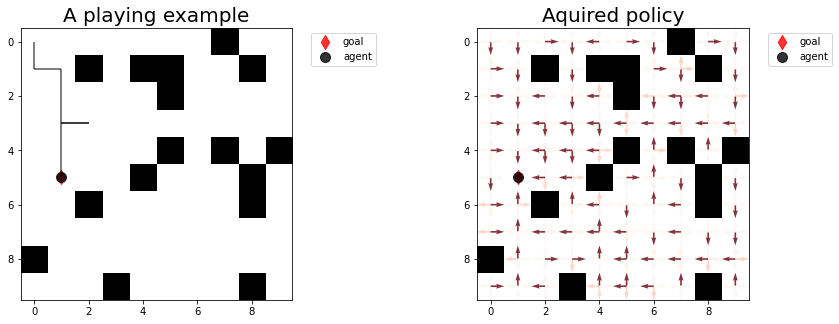

In [12]:
env.reset()

fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(121); ax1.set_title("A playing example", fontsize=20) 
ax2 = fig.add_subplot(122); ax2.set_title("Aquired policy", fontsize=20) 

env.play(agent, fig=fig, ax=ax1, canvas=True)
env.render(fig=fig, ax=ax2, values_table=agent.policy.Q)

SARSAより無駄な動きが少なくなるのがわかります。これはQ学習が常に最適方策を探そうとしているためです。

#### コラム:ヘンゼルとグレーテル
ここまでの迷路の例は、丁度、グリム童話の**ヘンゼルとグレーテル**が森に迷い込んだ時にパンを少しずつちぎって森の入口から落としていったように、ゴールに辿り着いたときの報酬が、エピソードを重ねる毎にじわじわと迷路全域に広がってゆくのが確認できます。

これを見れば、なぜこれまでの手法で上手く解けたのか一目瞭然です：

/Users/akinoritanaka/.pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/ipykernel/__main__.py:98: RuntimeWarning: invalid value encountered in true_divide


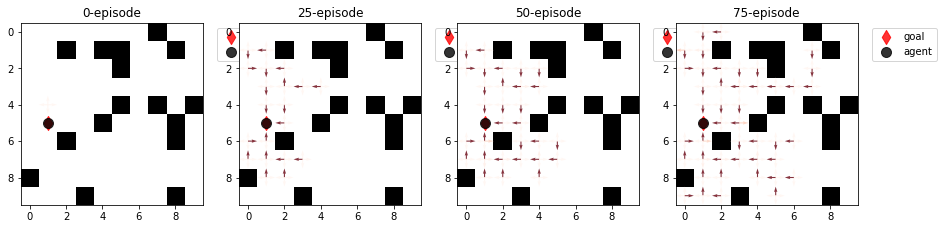

CPU times: user 1.73 s, sys: 210 ms, total: 1.94 s
Wall time: 1.21 s


In [13]:
%%time
agent = Agent(policy=EpsilonGreedy(env=env, init=0))
Opt = Qlearning_optimizer(agent, eta=1., gamma=0.2)
N_episode = 100
N_show = 4

fig = plt.figure(figsize=(15, 5))
for i in range(N_show):
    fig.add_subplot(1,N_show,i+1)

i = 0
for episode in range(N_episode):
    env.reset()
    while not env.is_solved():
        s = env.get_state()
        a = agent.play()
        s_next, r_next, _, _ = env.step(a)
        Opt.update(s, a, r_next, s_next)
        if env.t > 100: # たまにゴールできない位置に置かれてしまうので
            break
    if episode%(N_episode//N_show)==0:
        #print(i, episode)
        ax = fig.axes[i]
        ax.set_title("{}-episode".format(episode))
        env.render(fig=fig, ax=ax, values_table=agent.policy.Q, canvas=True)
        i+=1
plt.show()

#### Double Q-learning
Q学習については、**maximization bias**と呼ばれる、学習初期で「間違って」推定してしまった $Q$ の値に $max$ 操作が引きずられてしまい、学習が遅くなることが指摘されており、これを改善するため、

$$
\cdots \to (-, s,a) \to (r_\text{next}, s_\text{next},-) \to \cdots
$$

について確率1/2で

$$
Q^{(k+1)}_1(s,a) = Q^{(k)}_1(s,a) - \eta \Big(
Q^{(k)}_1(s,a) - \big[
r_\text{next}
+
\gamma Q^{(k)}_2(s_\text{next}, \text{argmax}_{a'}[Q^{(k)}_1(s_\text{next}, a')]) 
\big]
\Big)
\\
Q^{(k+1)}_2(s,a) = Q^{(k)}_2(s,a) - \eta \Big(
Q^{(k)}_2(s,a) - \big[
r_\text{next}
+
\gamma Q^{(k)}_1(s_\text{next}, \text{argmax}_{a'}[Q^{(k)}_2(s_\text{next}, a')]) 
\big]
\Big)
$$

の更新をし、

$$
Q(s,a) = Q_1(s,a) + Q_2(s,a)
$$

と取る手法、**double Q-learning**と呼ばれる手法が派生手法として提案されています：[Hado V. Hasselt(NIPS2010)](https://papers.nips.cc/paper/3964-double-q-learning)。誰か実装してみて下さい。

### モデルベース手法
さて、ヘンゼルとグレーテルの例を見ると、これまでの手法が

1. ゴールに着くまでは何も更新されず
2. ゴールに到達したエピソードでは、ゴールから1マス前に**のみ**報酬が伝搬し
3. それが繰り返されることでゴールから逆向きに報酬が伝搬し、迷路全域に広まれば解けた

ことになる、というシナリオを踏襲していることがわかります。（アニメーションなどにするともっと分かりやすいのですが、アニメーションはやや重いので割愛します）

これはなるほど、と思いますが、よく考えるとゴールした後のエピソードでも、2の1マスか、ゴールにたどり着かないと何も更新されないわけです。前のエピソードで一回ゴールしたのであれば、少なくともそのルートは覚えておくのが普通ですが、それすら行われないのは効率的でないでしょう。

かといって、一回ゴールした道のりは最適な経路ではない可能性もありますから、丸覚えは駄目な気がします。そこで登場するのが**環境をモデル化し、環境の振る舞いを学習する**ということです。このような、環境のモデル学習も組み込んだ強化学習の手法を **モデルベース強化学習** といいます。



#### Dyna-Q
ここではQ学習に、環境の振る舞いをテーブルに「記憶するだけ」のモデルを組み込んだ**dyna-Q**と呼ばれる手法を紹介しましょう。まず環境モデルは以下のようなもので、

- `S2_A2SR`: 記憶した状態と行動を入力すると次の状態と報酬を返す
- `memorize(self, S, A, S_next, R_next)`: 記憶する
- `simulate(self)`: 記憶した中からランダムに1ステップの振る舞いを再生する

などの機能を持ったクラスです：

In [14]:
class ReplayModel():
    def __init__(self, env):
        self.reset()
        #self.env = env
        
    def reset(self):
        self.S2_A2SR = {}
    
    def memorize(self, S, A, S_next, R_next):
        x, y = S
        x_next, y_next = S_next
        if (x, y) not in list(self.S2_A2SR.keys()):
            self.S2_A2SR.setdefault((x, y), {})
            
        self.S2_A2SR[(x, y)][A] = (x_next, y_next, R_next)
        # ここはデフォルトセットにしてはいけない（後で振る舞いが変わるかもしれないので、そのときは後を優先して上書き）
        # 迷路では問題ないと思われる
        
    def simulate(self):
        '''
        1: sample S from memory
        2: sample A from A(S) in memory
        3: get S_next, R_next from S, A
        return: S, A, S_next, R_next
        '''
        xys = list(self.S2_A2SR.keys())
        x, y = xys[np.random.randint(len(xys))]
        As = list(self.S2_A2SR[(x, y)].keys())
        A = As[np.random.randint(len(As))]
        
        x_next, y_next, R_next = self.S2_A2SR[(x, y)][A]
        return np.array([x, y]), A, np.array([x_next, y_next]), R_next

この環境モデルの記憶ステップと、それを用いた訓練ステップが入るところ以外は全くQ学習とかわりません。ここでは毎時刻で環境モデルからランダムな環境の振る舞いがリプレイされるような手法を取っています：

In [15]:
%%time
agent = Agent(policy=EpsilonGreedy(env=env))
Opt = Qlearning_optimizer(agent, eta=1., gamma=0.2)
N_episode = 100

Model = ReplayModel(env)
N_planning = 5

for episode in range(N_episode):
    env.reset()
    while not env.is_solved():
        s = env.get_state()
        a = agent.play()
        s_next, r_next, _, _ = env.step(a)
        Opt.update(s, a, r_next, s_next)
        ### モデル学習
        Model.memorize(s, a, s_next, r_next)
        ### planning プレーをリプレイ
        for _ in range(N_planning):
            S, A, S_next, R_next = Model.simulate()
            Opt.update(S, A, R_next, S_next)
        if env.t > 100: # たまにゴールできない位置に置かれてしまうので
            break

CPU times: user 479 ms, sys: 6.9 ms, total: 486 ms
Wall time: 488 ms


エピソード数を500から100に減らし、代わりにリプレイ回数を5回にしましたが、Q学習よりやや早いのがわかります。訓練のタイミングが2箇所ありますが、それぞれ

- 今まで通り、本物の環境との相互作用で訓練する部分：direct RL
- 環境モデルの振る舞いで訓練する部分：プランニング

と呼びます。方策もQ学習と同程度に改善されたものが得られます：

/Users/akinoritanaka/.pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/ipykernel/__main__.py:98: RuntimeWarning: invalid value encountered in true_divide


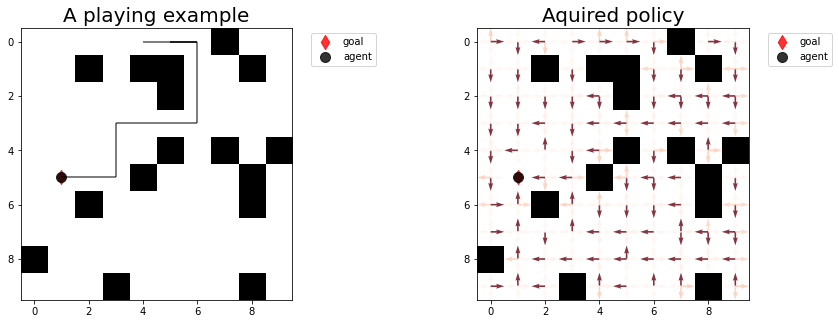

In [16]:
env.reset()

fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(121); ax1.set_title("A playing example", fontsize=20) 
ax2 = fig.add_subplot(122); ax2.set_title("Aquired policy", fontsize=20) 

env.play(agent, fig=fig, ax=ax1, canvas=True)
env.render(fig=fig, ax=ax2, values_table=agent.policy.Q)

#### 関連する手法
更に、プランニング内容を改良したdyna-Q+と言う手法が http://www.incompleteideas.net/book/the-book-2nd.html では紹介されています。また、畳み込みニューラルネットを用いたQ学習でアタリ社のゲームを強化学習する**深層Q学習ネットワーク(Deep Q-Network, DQN)**([arXiv:1312.5602](https://arxiv.org/abs/1312.5602)) では、経験リプレイと呼ばれる、dyna-Qに似たプランニングによる訓練が行われています。また、有名なアルファ碁ではモンテカルロ木探索がプランニングです。